# Libraries

##  Remove warnings

In [39]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [40]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import random
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# Torch libraries
#
import torch
import torch.nn                     as nn
import torch.nn.functional          as F
from   torch.utils.data             import DataLoader
from   torch.utils.data             import Dataset


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.EarlyStopping      import *
from utils.LRScheduler        import *

# Parameters

## CUDA

In [41]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

2.2.0
12.1
True


In [42]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(f"[INFO] Using GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("[INFO] Using CPU")

[INFO] Using GPU: NVIDIA GeForce GTX 1660 SUPER


## Neural networks parameters

In [43]:
class Parameters():
    def __init__(self):
        self.description = 'DLinear model for time-series forecasting'
        self.model_name = 'DLinear'
        
        # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
        # Neural network model parameters
        #
        # Input sequence length - look-back
        self.Lag         = 96
        # Prediction sequence length
        self.Horizon     = 96
        #
        self.individual  = False
        self.enc_in      = 1
        self.kernel_size = 25
        
        # Training parameters
        #
        # Number of epochs
        self.epochs        = 1000
        # Batch size
        self.batch_size    = 32
        # Number of workers in DataLoader
        self.num_workers   = 0
        # Define verbose
        self.verbose       = True
        # Learning rate
        self.learning_rate = 1e-4
        # Trained model path
        self.model_path    = 'models/electricity/DLinear_0.pth'
        
        # Data handling
        #
        # Filename
        self.filename              = './data/Electricity/Electricity.csv'
        # Target series name 
        self.targetSeries          = '0'
        # Training-set percentage
        self.TrainingSetPercentage = 0.8
        # Data Log-transformation
        self.Transformation        = True
        # Scaling {'Standard', 'MinMax', 'Robust'}
        self.Scaling               = 'Standard'

args = Parameters()

# Data handling

## Import data


In [44]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( args.filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 1.11 seconds


,date,0,1,2,3,4,5,6,7,8,...,311,312,313,314,315,316,317,318,319,OT
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0


## Preprocess data

### Set index

In [45]:
# Convert Date to 'datetime64'
#
df['date'] = df['date'].astype('datetime64[ns]')

# Set index
#
df.set_index('date', inplace=True)


# Keep only selected time-series
#
df = pd.DataFrame( df[ [ args.targetSeries ] ] )


df.head( 3 )

,0
date,
2016-07-01 02:00:00,14.0
2016-07-01 03:00:00,18.0
2016-07-01 04:00:00,21.0


### H and windows_complexity

In [46]:
from H_estimation.LZ1 import *
from H_estimation.LZ2 import *
from H_estimation.compute_PIMax import *

In [47]:
series = df[args.targetSeries].values
epsilon = [0.1]
for e in epsilon:
    N = (max(series)-min(series)+2*e)/e
    H = Compute_LZ2(series,e)
    Pi_max = get_pimax(H,N)
    print(f"Epsilon: {e}, Entropy: {H:.4f}, Pi_max: {Pi_max:.4f}")

Epsilon: 0.1, Entropy: 2.9034, Pi_max: 0.7927


In [48]:
def window_wise_complexity(x, P, F, stride=1):
    """Compute window-wise complexity using FFT variance."""
    L = P + F
    if len(x) < L:
        return np.nan  # 序列太短
    windows = [x[i:i+L] for i in range(0, len(x)-L+1, stride)]
    A = np.array([np.abs(np.fft.fft(w)) for w in windows])
    mean_A = np.mean(A, axis=0)
    diff = A - mean_A
    complexity = np.mean(np.sum(diff**2, axis=1))
    return complexity

In [49]:
window_complexity = window_wise_complexity(series, args.Lag, args.Horizon)
print(f"Window-wise Complexity: {window_complexity:.4f}")

Window-wise Complexity: 17830151.2252


### Split Training/Testing

In [50]:
idx = int( df.shape[0] * args.TrainingSetPercentage )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

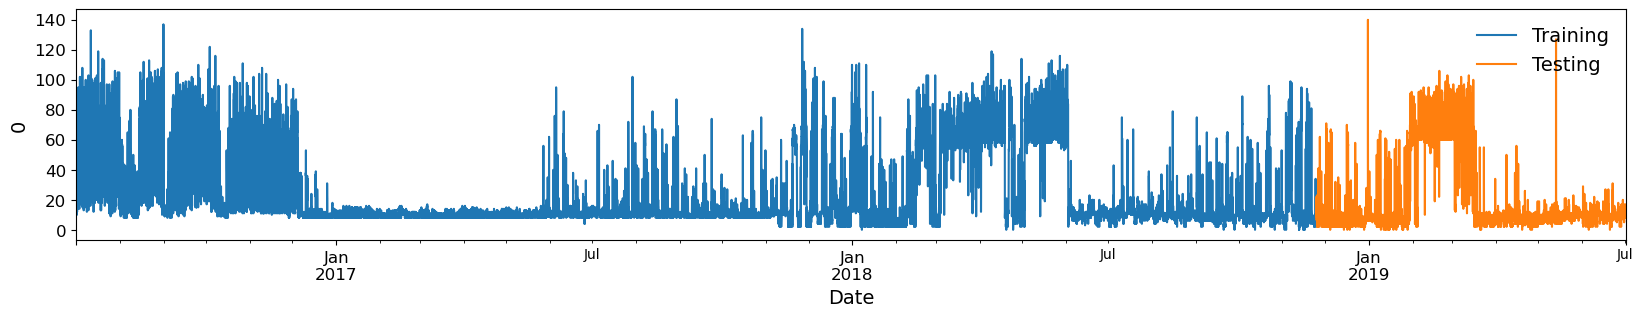

In [51]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ args.targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ args.targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(args.targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [52]:
df_test = pd.concat([df_train.iloc[-args.Lag:], df_test])

## Preprocessing

## Data Transformation

In [53]:
if (args.Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = np.ceil( max(abs( -df.min().min() ), 1.0) )
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [54]:
if (args.Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df[ args.targetSeries ] = scaler.fit_transform( df[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
            
elif (args.Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df[ args.targetSeries ] = scaler.fit_transform( df[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )
        
elif (args.Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df[ args.targetSeries ] = scaler.fit_transform( df[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )             
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature ==  args.targetSeries ): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df[ args.targetSeries ] = scaler.fit_transform( df[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_train[ args.targetSeries ] = scaler.fit_transform( df_train[  args.targetSeries  ].to_numpy().reshape(-1,1) )
    df_test[ args.targetSeries ]  = scaler.transform( df_test[  args.targetSeries  ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard


In [55]:
series = df[args.targetSeries].values

In [56]:
window_complexity = window_wise_complexity(series, args.Lag, args.Horizon)
print(f"Window-wise Complexity: {window_complexity:.4f}")

Window-wise Complexity: 14770.7814


## Create Training/Testing data

In [57]:
def create_dataset(df = None, Lag = 1, Horizon = 1, targetSeries = None, overlap = 1):
    
    if (targetSeries is None):
        targetSeries = df.columns[-1]
    
    dataX, dataY, dataDate = [], [], []
    
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):
        
        dataX.append( df.to_numpy()[i:(i+Lag)] )        
        dataY.append( df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon] )
        dataDate.append( df.index[i + Lag : i + Lag + Horizon].tolist() )
        
    return ( np.array(dataX), np.array(dataY), np.array(dataDate) )


In [58]:
trainX, trainY, _ = create_dataset(df           = df_train, 
                                   Lag          = args.Lag, 
                                   Horizon      = args.Horizon, 
                                   targetSeries = args.targetSeries,
                                   overlap      = 1,)
                               

testX,  testY, testDate  = create_dataset(df           = df_test, 
                                          Lag          = args.Lag, 
                                          Horizon      = args.Horizon, 
                                          targetSeries = args.targetSeries,
                                          overlap      = 1,)


# Last 10% of the training data will be used for validation
#
idx = int(0.9 * trainX.shape[0])
validX, validY = trainX[ idx: ], trainY[ idx: ]
trainX, trainY = trainX[ :idx ], trainY[ :idx ]

print('Training data shape:   ', trainX.shape, trainY.shape)
print('Validation data shape: ', validX.shape, validY.shape)
print('Testing data shape:    ', testX.shape,  testY.shape)

  0%|          | 0/20852 [00:00<?, ?it/s]

100%|██████████| 5166/5166 [00:00<00:00, 9807.86it/s]


Training data shape:    (18766, 96, 1) (18766, 96)
Validation data shape:  (2086, 96, 1) (2086, 96)
Testing data shape:     (5166, 96, 1) (5166, 96)


In [59]:
# Reshaping
#
trainY = np.expand_dims(trainY, axis = -1)
validY = np.expand_dims(validY, axis = -1)
testY  = np.expand_dims(testY,  axis = -1)

In [60]:
class Data( Dataset ):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)
    
    def __getitem__(self, idx):
        return self.X[ idx ], self.Y[ idx ]
    

    
# Create training and test dataloaders
#
train_ds = Data(trainX, trainY)
valid_ds = Data(validX, validY)
test_ds  = Data(testX,  testY)


# Prepare Data-Loaders
#
train_dl = DataLoader(train_ds, batch_size = args.batch_size, num_workers = args.num_workers)
valid_dl = DataLoader(valid_ds, batch_size = args.batch_size, num_workers = args.num_workers)
test_dl  = DataLoader(test_ds,  batch_size = args.batch_size, num_workers = args.num_workers)
#
print('[INFO] Data loaders were created')

[INFO] Data loaders were created


# Forecasting model: DLinear

In [61]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean

class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, configs):
        super(Model, self).__init__()
        self.Lag  = configs.Lag
        self.Horizon = configs.Horizon

        # Decompsition Kernel Size
        kernel_size       = configs.kernel_size
        self.decompsition = series_decomp(kernel_size)
        self.individual   = configs.individual
        self.channels     = configs.enc_in

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend    = nn.ModuleList()
            self.Linear_Decoder  = nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Seasonal.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Seasonal[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Trend.append(nn.Linear(self.Lag,self.Horizon))
                self.Linear_Trend[i].weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
                self.Linear_Decoder.append(nn.Linear(self.Lag,self.Horizon))
        else:
            self.Linear_Seasonal = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Trend = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Decoder = nn.Linear(self.Lag,self.Horizon)
            self.Linear_Seasonal.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))
            self.Linear_Trend.weight = nn.Parameter((1/self.Lag)*torch.ones([self.Horizon,self.Lag]))

    def forward(self, x):
        # x: [Batch, Input length, Channel]
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(0,2,1), trend_init.permute(0,2,1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0),seasonal_init.size(1),self.Horizon],dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0),trend_init.size(1),self.Horizon],dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:,i,:] = self.Linear_Seasonal[i](seasonal_init[:,i,:])
                trend_output[:,i,:] = self.Linear_Trend[i](trend_init[:,i,:])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)

        x = seasonal_output + trend_output
        return x.permute(0,2,1) # to [Batch, Output length, Channel]

## Setup model

In [62]:
# Initialize Neural Network
# 
model = Model( args )

model.to( device )


print( model )

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=96, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=96, out_features=96, bias=True)
  (Linear_Decoder): Linear(in_features=96, out_features=96, bias=True)
)


## Training parameters

In [63]:
# Specify loss function
#
criterion = nn.MSELoss()

# Specify loss function
#
optimizer = torch.optim.Adam(params = model.parameters(), 
                             lr     = args.learning_rate)




# Early stopping
#
early_stopping = EarlyStopping(patience  = 100,
                               min_delta = 1e-5)


# LR scheduler
#
scheduler = LRScheduler(optimizer = optimizer, 
                        patience  = 50, 
                        min_lr    = 1e-10, 
                        factor    = 0.5, 
                        verbose   = args.verbose)

## Training process

In [64]:
# Store training and validation loss
Loss = {
         'Train': [], 
         'Valid':  []
       }



# Set number at how many iteration the training process (results) will be provided
#
batch_show = (train_dl.dataset.__len__() // args. batch_size // 5)



# Main loop - Training process
#
for epoch in range(1, args.epochs+1):

    # Start timer
    start = time.time()
    
    # Monitor training loss
    #
    train_loss = 0.0
    valid_loss  = 0.0    
    
    
    
    ###################
    # Train the model #
    ###################
    batch_idx = 0
    for data, target in train_dl:
        
        # Clear the gradients of all optimized variables
        #
        optimizer.zero_grad()
        
        # Forward pass: compute predicted outputs by passing inputs to the model
        #
        if (device.type == 'cpu'):
            data   = torch.tensor(data,   dtype=torch.float32)
            target = torch.tensor(target, dtype=torch.float32)
        else:
            data   = torch.tensor(data,   dtype=torch.float32).cuda()
            target = torch.tensor(target, dtype=torch.float32).cuda()

            
        outputs = model( data )
        

        
        # Calculate the loss
        #
        loss = criterion(outputs, target)
        
        
        
        # Backward pass: compute gradient of the loss with respect to model parameters
        #
        loss.backward()
        
        
        
        # Perform a single optimization step (parameter update)
        #
        optimizer.step()
        
        
        
        # Update running training loss
        #
        train_loss += loss.item()*data.size(0)
               
        # Increase batch_idx
        #
        batch_idx  += 1
        
        
        # Info
        #
        if (args.verbose == True and batch_idx % batch_show == 0):
            print('> Epoch: {} [{:5.0f}/{} ({:.0f}%)]'.format(epoch, batch_idx * len(data), len(train_dl.dataset), 100. * batch_idx / len(train_dl)))        

           
        
    # Print avg training statistics 
    #
    train_loss = train_loss / train_dl.dataset.X.shape[0]

    
    
    
    
    with torch.no_grad():
        for data, target in valid_dl:

            # Forward pass: compute predicted outputs by passing inputs to the model
            #
            if (device.type == 'cpu'):
                data   = torch.tensor(data, dtype=torch.float32)
                target = torch.tensor(target, dtype=torch.float32)
            else:
                data   = torch.tensor(data, dtype=torch.float32).cuda()
                target = torch.tensor(target, dtype=torch.float32).cuda()


            outputs = model( data )
        
          

            # Calculate the loss
            #
            loss = criterion(outputs, target)
                
            # update running training loss
            valid_loss += loss.item()*data.size(0)
              

    # Print avg training statistics 
    #
    valid_loss = valid_loss / test_dl.dataset.X.shape[0]






    # Stop timer
    #
    stop  = time.time()
    
    
    # Show training results
    #
    print('\n[INFO] Train Loss: {:.6f}\tValid Loss: {:.6f} \tTime: {:.2f}secs'.format(train_loss, valid_loss, stop-start), end=' ')

   
    

    # Update best model
    #
    if (epoch == 1):
        Best_score = valid_loss
        
        torch.save(model.state_dict(), args.model_path)
        print('(Model saved)\n')
    else:
        if (Best_score > valid_loss):
            Best_score = valid_loss
            
            torch.save(model.state_dict(), args.model_path)
            print('(Model saved)\n')
        else:
            print('\n')
     
    
    # Store train/val loss
    #
    Loss['Train'] += [ train_loss ]
    Loss['Valid'] += [ valid_loss ]
    

    
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Learning rate scheduler
    #
    scheduler( valid_loss )
    
    
    # =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
    # Early Stopping
    #
    if ( early_stopping( valid_loss ) ): break

> Epoch: 1 [ 3744/18766 (20%)]
> Epoch: 1 [ 7488/18766 (40%)]
> Epoch: 1 [11232/18766 (60%)]
> Epoch: 1 [14976/18766 (80%)]
> Epoch: 1 [18720/18766 (100%)]

[INFO] Train Loss: 0.516368	Valid Loss: 0.354380 	Time: 1.26secs (Model saved)

> Epoch: 2 [ 3744/18766 (20%)]
> Epoch: 2 [ 7488/18766 (40%)]
> Epoch: 2 [11232/18766 (60%)]
> Epoch: 2 [14976/18766 (80%)]
> Epoch: 2 [18720/18766 (100%)]

[INFO] Train Loss: 0.485921	Valid Loss: 0.352030 	Time: 1.21secs (Model saved)

> Epoch: 3 [ 3744/18766 (20%)]
> Epoch: 3 [ 7488/18766 (40%)]
> Epoch: 3 [11232/18766 (60%)]
> Epoch: 3 [14976/18766 (80%)]
> Epoch: 3 [18720/18766 (100%)]

[INFO] Train Loss: 0.473473	Valid Loss: 0.351643 	Time: 1.37secs (Model saved)

> Epoch: 4 [ 3744/18766 (20%)]
> Epoch: 4 [ 7488/18766 (40%)]
> Epoch: 4 [11232/18766 (60%)]
> Epoch: 4 [14976/18766 (80%)]
> Epoch: 4 [18720/18766 (100%)]

[INFO] Train Loss: 0.466518	Valid Loss: 0.351852 	Time: 1.39secs 

> Epoch: 5 [ 3744/18766 (20%)]
> Epoch: 5 [ 7488/18766 (40%)]
> E

## Load optimized model

In [65]:
# Load best model
#
model.load_state_dict( torch.load( args.model_path ) );
model.eval();

print('[INFO] Model loaded')

[INFO] Model loaded


In [66]:
device = 'cpu'
model.to( device )

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=96, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=96, out_features=96, bias=True)
  (Linear_Decoder): Linear(in_features=96, out_features=96, bias=True)
)

## Evaluation

### Get predictions

In [67]:
pred = None
with torch.no_grad():
    for data, target in tqdm( test_dl ):

        data   = torch.tensor(data,   dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)

        if (pred is None):
            pred = model( data ).numpy()
        else:
            pred = np.concatenate([pred, model( data ).numpy()])

100%|██████████| 162/162 [00:00<00:00, 682.50it/s]


In [68]:
# Reshaping...
#
testY = testY.squeeze(-1)
pred  = pred.squeeze(-1)

### Apply inverse scaling/transformation

In [69]:
# Apply inverse scaling
#
for i in range( args.Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (args.Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [70]:
import os

In [71]:
def save_metrics_to_file(model_name, target_col, metrics, horizon, H, window_complexity):
    """将评估指标保存到文件"""
    filename = "model_metrics.csv"
    
    # 检查文件是否存在,不存在则创建并写入表头
    if not os.path.exists(filename):
        with open(filename, "w") as f:
            f.write("model,target,mse,mae,rmse,horizon,H,window_complexity\n")
    
    # 添加新的评估结果
    with open(filename, "a") as f:
        f.write(f"{model_name},{target_col},{metrics['MSE']:.4f},{metrics['MAE']:.4f},"
                f"{metrics['RMSE']:.4f},{horizon},{H}, {window_complexity}\n")

In [72]:
print('[INFO] Feature: ', args.targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : [], 'MSE': []}

for i in range( args.Horizon ):

    Prices = pd.DataFrame([])        

    Prices[ args.targetSeries ] = testY[:,i]
    Prices[ 'Prediction'      ] = pred[:,i]


    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2, MSE = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE    ]
    Performance_Foresting_Model['MAE']     += [ MAE     ]
    # Performance_Foresting_Model['MAPE']    += [ MAPE    ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE   ]
    Performance_Foresting_Model['R2']      += [ R2      ]
    Performance_Foresting_Model['MSE']     += [ MSE     ]

    # Present results
    #
    print('Horizon: %2i MAE %5.2f RMSE %5.2f SMAPE: %5.2f R2: %.2f MSE: %.2f' % (i+1, MAE, RMSE, SMAPE, R2, MSE))


[INFO] Feature:  0
------------------------------------------------
Horizon:  1 MAE  4.94 RMSE 10.37 SMAPE: 28.61 R2: 0.82 MSE: 107.51
Horizon:  2 MAE  5.63 RMSE 11.41 SMAPE: 31.56 R2: 0.78 MSE: 130.12
Horizon:  3 MAE  5.66 RMSE 11.53 SMAPE: 32.37 R2: 0.78 MSE: 133.00
Horizon:  4 MAE  5.37 RMSE 11.34 SMAPE: 32.21 R2: 0.79 MSE: 128.65
Horizon:  5 MAE  5.88 RMSE 11.92 SMAPE: 33.87 R2: 0.76 MSE: 142.04
Horizon:  6 MAE  6.09 RMSE 12.19 SMAPE: 34.63 R2: 0.75 MSE: 148.64
Horizon:  7 MAE  5.70 RMSE 11.90 SMAPE: 34.25 R2: 0.76 MSE: 141.70
Horizon:  8 MAE  6.10 RMSE 12.35 SMAPE: 35.24 R2: 0.75 MSE: 152.63
Horizon:  9 MAE  6.41 RMSE 12.71 SMAPE: 35.99 R2: 0.73 MSE: 161.43
Horizon: 10 MAE  5.86 RMSE 12.19 SMAPE: 35.23 R2: 0.75 MSE: 148.67
Horizon: 11 MAE  5.98 RMSE 12.42 SMAPE: 35.27 R2: 0.74 MSE: 154.24
Horizon: 12 MAE  7.01 RMSE 13.40 SMAPE: 37.56 R2: 0.70 MSE: 179.63
Horizon: 13 MAE  6.25 RMSE 12.77 SMAPE: 35.66 R2: 0.73 MSE: 163.12
Horizon: 14 MAE  6.41 RMSE 12.95 SMAPE: 35.94 R2: 0.72 MSE: 1

In [73]:
metrics = {'MSE': MSE, 'MAE': MAE, 'RMSE': RMSE}
save_metrics_to_file(   model_name=args.model_name,
                        target_col=args.targetSeries,
                        metrics=metrics,
                        horizon=args.Horizon,
                        H = H,
                        window_complexity=window_complexity)